In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [2]:
info_df = pd.read_excel('inventory_data.xlsx', sheet_name='Inf.')
accounting_info_df = pd.read_excel('inventory_data.xlsx', sheet_name='Info comptable')
sales_2023_df = pd.read_excel('inventory_data.xlsx', sheet_name='Vendes 2023')
sales_2022_df = pd.read_excel('inventory_data.xlsx', sheet_name='Vendes 2022')
catalog_prices_2023_df = pd.read_excel('inventory_data.xlsx', sheet_name='Preus de venda catàleg 2023')
last_exit_entry_df = pd.read_excel('inventory_data.xlsx', sheet_name='Darrera entrada-sortida')
stock_31_12_2023_df = pd.read_excel('inventory_data.xlsx', sheet_name='Stock 31.12.23')

In [3]:
last_exit_entry_df['Data darrera sortida'] = pd.to_datetime(last_exit_entry_df['Data darrera sortida'], format='%m/%d/%Y')
last_exit_entry_df['Data darrera entrada'] = pd.to_datetime(last_exit_entry_df['Data darrera entrada'], format='%m/%d/%Y')
last_exit_entry_df['Inventory Age'] = (pd.Timestamp('2024-04-13') - last_exit_entry_df['Data darrera entrada']).dt.days
last_exit_entry_df['Last sale'] = (pd.Timestamp('2024-04-13') - last_exit_entry_df['Data darrera sortida']).dt.days

In [4]:
merged_df = pd.merge(stock_31_12_2023_df, last_exit_entry_df[['Material (Referencia)', 'Inventory Age', 'Last sale']], on='Material (Referencia)', how='left')
merged_df = pd.merge(merged_df, sales_2023_df, on='Material (Referencia)', how='left')

sales_2022_df = sales_2022_df.rename(columns=lambda x: x + "2022" if x != "Material (Referencia)" else x)
merged_df = pd.merge(merged_df, sales_2022_df, on='Material (Referencia)', how='left')
merged_df = merged_df.rename(columns=lambda x: x.strip())

Clustering? nose

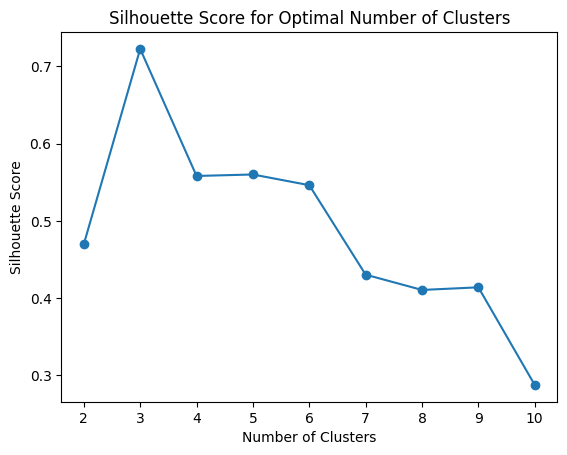

In [5]:
cluster_features = ['Stock total', 'Valor total', 'Inventory Age', 'Last sale', "Quantitat facturada", "Ventes (sense IVA)"]

cluster_df = merged_df.dropna(subset=cluster_features)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(cluster_df[cluster_features])

# Gràcies Karina per tant
silhouette_scores = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_features)
    silhouette_avg = silhouette_score(scaled_features, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot silhouette
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal Number of Clusters')
plt.show()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_10140\234955633.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df['Cluster'] = cluster_labels
C:\Users\Usuario\AppData\Local\Temp\ipykernel_10140\234955633.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df['PCA Component 1'] = pca_features[:, 0]
C:\Users\Usuario\AppData\Local\Temp\ipykernel_10140\234955633.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

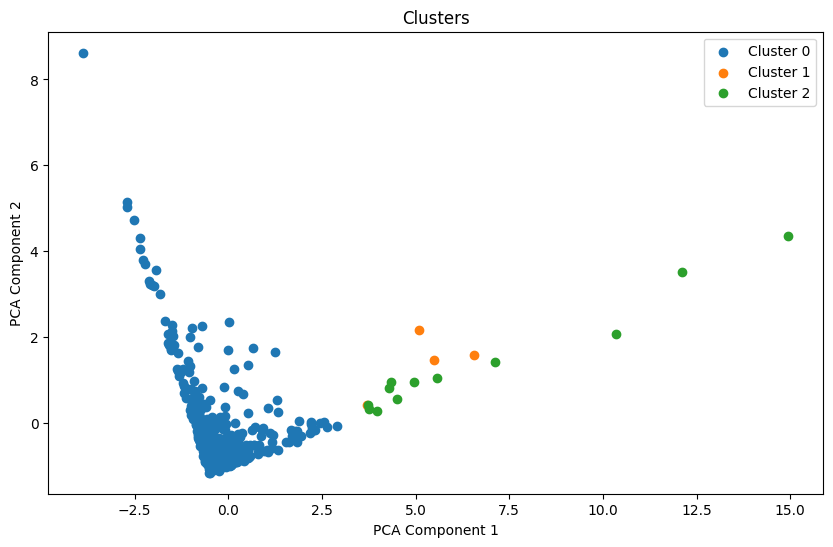

In [6]:
optimal_n_clusters = 3 
kmeans = KMeans(n_clusters=optimal_n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(scaled_features)
cluster_df['Cluster'] = cluster_labels

pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)
cluster_df['PCA Component 1'] = pca_features[:, 0]
cluster_df['PCA Component 2'] = pca_features[:, 1]
plt.figure(figsize=(10, 6))
for cluster in range(optimal_n_clusters):
    plt.scatter(cluster_df[cluster_df['Cluster'] == cluster]['PCA Component 1'],
                cluster_df[cluster_df['Cluster'] == cluster]['PCA Component 2'],
                label=f'Cluster {cluster}')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Clusters')
plt.legend()
plt.show()

Vaia merda només agrupa els que es venen més crec

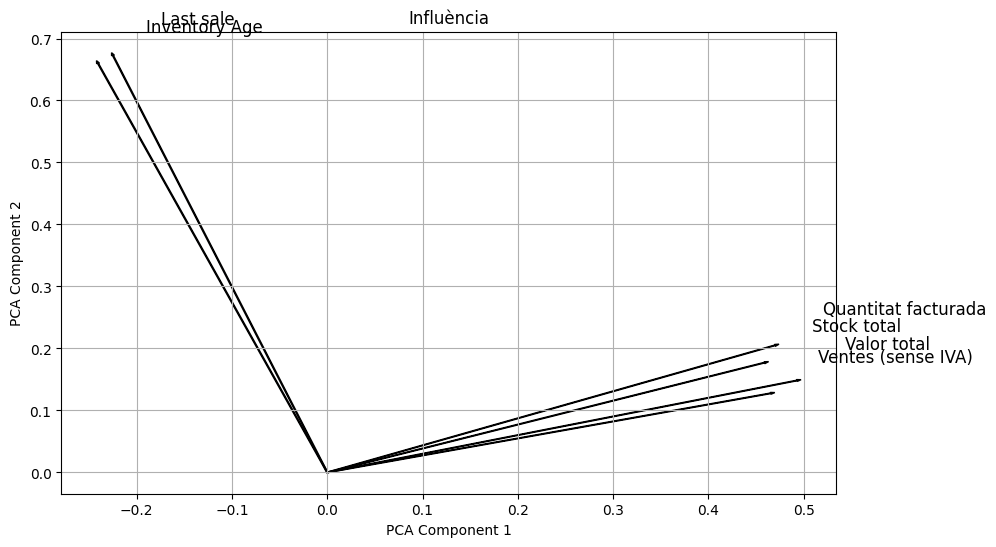

In [7]:
#Per veure els components
plt.figure(figsize=(10, 6))
for i, feature in enumerate(cluster_features):
    plt.arrow(0, 0, pca.components_[0, i], pca.components_[1, i])
    plt.text(pca.components_[0, i] + 0.05, pca.components_[1, i] + 0.05, feature, fontsize='12')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Influència')
plt.grid()
plt.show()

Detecció de outliers, ja que és probable que els outliers indiquin que s'hauria de disminuïr el seu valor.

C:\Users\Usuario\AppData\Local\Temp\ipykernel_10140\3496404377.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df['Outlier'] = outlier_labels


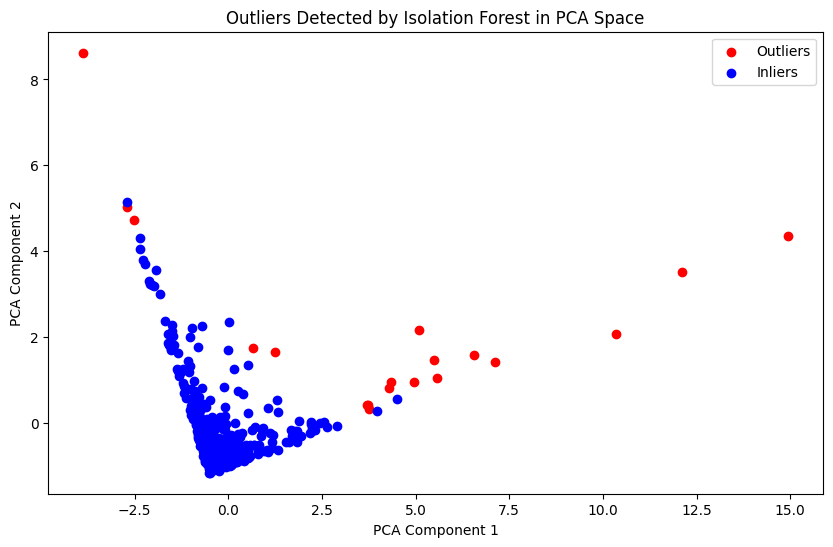

In [8]:
from sklearn.ensemble import IsolationForest

# Isolation Forest per detectar outliers
isolation_forest = IsolationForest(contamination=0.05, random_state=42)
outlier_labels = isolation_forest.fit_predict(scaled_features)
cluster_df['Outlier'] = outlier_labels

# Visualitzem al mateix PCA
plt.figure(figsize=(10, 6))
plt.scatter(cluster_df[cluster_df['Outlier'] == -1]['PCA Component 1'],
            cluster_df[cluster_df['Outlier'] == -1]['PCA Component 2'],
            color='red', label='Outliers')
plt.scatter(cluster_df[cluster_df['Outlier'] == 1]['PCA Component 1'],
            cluster_df[cluster_df['Outlier'] == 1]['PCA Component 2'],
            color='blue', label='Inliers')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Outliers Detected by Isolation Forest in PCA Space')
plt.legend()
plt.show()

Detecta outliers que són que tenen valors molt alts, però també alguns que és perquè fa molt que no es venen diria. Aquests segurament s'haurà de devaluar el preu. El problema esq no crec que ho estigui fent bé pq clar no estic tinguent en compte si el preu és alt o baix: igual ja l'han devaluat o algo saps

Mètriques financeres del Chat GPT

In [9]:
# Calculate financial metrics
# For example, inventory turnover, days sales of inventory (DSI), and inventory-to-sales ratio

merged_df = merged_df.dropna()
merged_df['Total Sales 2023'] = merged_df['Quantitat facturada'] * merged_df['Ventes (sense IVA)']
merged_df['Total Sales 2022'] = merged_df['Quantitat facturada2022'] * merged_df['Ventes (sense IVA)2022']

# Calculate inventory turnover
merged_df['Inventory Turnover 2023'] = merged_df['Total Sales 2023'] / merged_df['Valor total']
merged_df['Inventory Turnover 2022'] = merged_df['Total Sales 2022'] / merged_df['Valor total']

# Calculate days sales of inventory (DSI)
merged_df['DSI 2023'] = 365 / merged_df['Inventory Turnover 2023']
merged_df['DSI 2022'] = 365 / merged_df['Inventory Turnover 2022']


# Calculate inventory-to-sales ratio
merged_df['Inventory-to-Sales Ratio 2023'] = merged_df['Stock total'] / merged_df['Total Sales 2023']
merged_df['Inventory-to-Sales Ratio 2022'] = merged_df['Stock total'] / merged_df['Total Sales 2022']

merged_df.replace([np.inf, -np.inf], 0, inplace=True)
# Calculate average financial metrics
average_turnover_2023 = merged_df['Inventory Turnover 2023'].mean()
average_turnover_2022 = merged_df['Inventory Turnover 2022'].mean()
average_dsi_2023 = merged_df['DSI 2023'].mean()

average_dsi_2022 = merged_df['DSI 2022'].mean()
average_inventory_sales_ratio_2023 = merged_df['Inventory-to-Sales Ratio 2023'].mean()
average_inventory_sales_ratio_2022 = merged_df['Inventory-to-Sales Ratio 2022'].mean()

# Print average financial metrics
print(f"Average Inventory Turnover 2023: {average_turnover_2023}")
print(f"Average Inventory Turnover 2022: {average_turnover_2022}")
print(f"Average DSI 2023: {average_dsi_2023}")
print(f"Average DSI 2022: {average_dsi_2022}")
print(f"Average Inventory-to-Sales Ratio 2023: {average_inventory_sales_ratio_2023}")
print(f"Average Inventory-to-Sales Ratio 2022: {average_inventory_sales_ratio_2022}")


Average Inventory Turnover 2023: 806443872.9580975
Average Inventory Turnover 2022: 1038522995.9417745
Average DSI 2023: 0.0007915079754650646
Average DSI 2022: 0.0006305190634838196
Average Inventory-to-Sales Ratio 2023: 5.652771517741936e-05
Average Inventory-to-Sales Ratio 2022: 4.226525556401273e-05


C:\Users\Usuario\AppData\Local\Temp\ipykernel_10140\43952304.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df.replace([np.inf, -np.inf], 0, inplace=True)


Intent de model

Com que no sabia ben bé què predir, el que fa és intentar predir el ratio de stock vs vendes, i amb aquest si és massa alt vol dir que el producte no es vendrà l'any vinent i per tant, pot indicar que s'hauria de d'avaluar. tot i això, és tope pocho.

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

X = merged_df[[ 'Valor total', 'Quantitat facturada2022', 'Last sale', 'Ventes (sense IVA)2022', 'Cost unit', 'Inventory Age', 'Inventory Turnover 2022', 'DSI 2022', 'Total Sales 2022']]
y = merged_df['Inventory-to-Sales Ratio 2023']  # Target variable for recommendation

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=1000, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Mean Absolute Percentage Error: {mape}")

predictions = rf_model.predict(X)
merged_df['AI predictions'] = predictions

print(merged_df[['Material (Referencia)', 'Inventory-to-Sales Ratio 2023', 'AI predictions']])


Mean Squared Error: 7.264650986670521e-09
Mean Absolute Percentage Error: 31415968358.559616
     Material (Referencia)  Inventory-to-Sales Ratio 2023  AI predictions
1              135062142.0                   1.625777e-08    5.446979e-08
2              173051016.0                   4.326368e-08    7.475742e-08
3              143131023.0                   1.011179e-07    2.240251e-07
4              172620527.0                   1.453504e-07    1.579369e-07
6              135292430.0                   3.338374e-07    6.279241e-06
..                     ...                            ...             ...
374            133066421.0                   1.704158e-04    2.892371e-04
375            133066424.0                   4.133598e-05    2.673515e-05
377            133200405.0                   1.050933e-05    1.111197e-05
381            136170112.0                   8.961858e-07    8.603782e-06
382            136170186.0                   1.924002e-05    1.609487e-05

[296 rows x 3 colu

Mires les prediccions i si el resultat real està per sobre, significa que podria ser que hi haguessin masses provisions o masses poques ventes en funció de l'any anterior (ja que el model en principi prediu el ratio que hi hauria d'haver), llavors el seu valor hauria de ser disminuït.

In [11]:
# Si és més del 20%, patucasa baixa el preu
impairment_threshold = 1.2 

merged_df['Devaluacio'] = merged_df['Inventory-to-Sales Ratio 2023'] > (merged_df['AI predictions'] * impairment_threshold)
potential_impairments = merged_df[merged_df['Devaluacio']]

print(len(potential_impairments))
print("Potential Inventory Devaluations (Impairments crec en anglès):")
print(potential_impairments[['Material (Referencia)', 'Stock total', 'Valor total', 'AI predictions']])


51
Potential Inventory Devaluations (Impairments crec en anglès):
     Material (Referencia)  Stock total  Valor total  AI predictions
24             152440201.0    3162000.0     34971.72    2.118793e-07
37             172620595.0    7425600.0     25321.30    2.837245e-07
46             152420161.0    1480000.0     20942.00    8.105365e-07
51             182080224.0    1267200.0     19971.07    6.768637e-06
73             172620596.0    4263600.0     14538.88    3.826171e-06
82             173041800.0    1656000.0     12817.44    5.399278e-06
87             173041071.0    1587000.0     12283.38    1.828472e-06
98             153110157.0     520000.0     10540.40    1.534841e-06
116            152290216.0    1446000.0      8444.64    1.893691e-06
127            174020102.0     442000.0      7186.92    2.603930e-06
128            173240405.0     490000.0      7144.20    5.642558e-06
129            152430159.0    1780000.0      7137.80    2.687385e-06
134            173301002.0    1760000

Fem els outliers amb aquestes dades

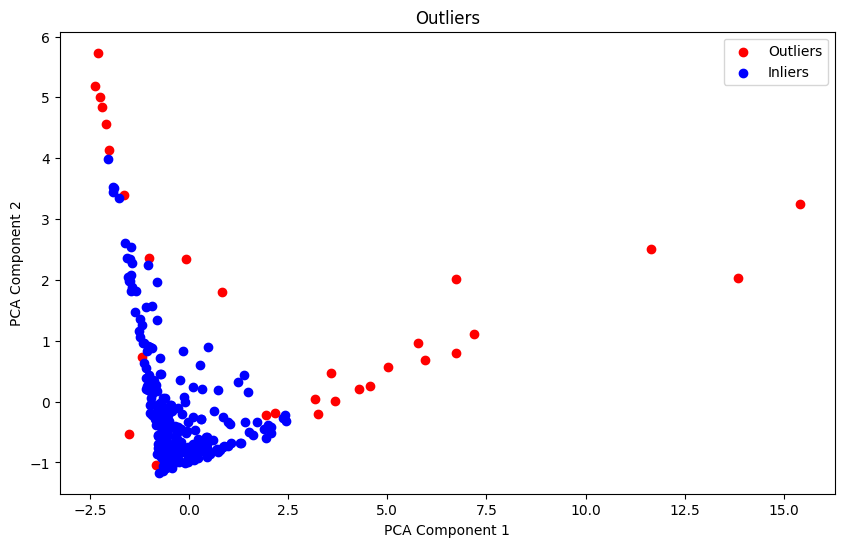

In [12]:
from sklearn.ensemble import IsolationForest


scaler = StandardScaler()
scaled_features = scaler.fit_transform(merged_df[['Valor total', 'Quantitat facturada', 'Stock total', 'Ventes (sense IVA)', 'Last sale', 'Ventes (sense IVA)2022', 'Inventory Age', 'DSI 2022']])


isolation_forest = IsolationForest(n_estimators=400, contamination=0.1, random_state=42)
outlier_labels = isolation_forest.fit_predict(scaled_features)
merged_df['Outlier'] = outlier_labels


pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)
merged_df['PCA Component 1'] = pca_features[:, 0]
merged_df['PCA Component 2'] = pca_features[:, 1]

plt.figure(figsize=(10, 6))
plt.scatter(merged_df[merged_df['Outlier'] == -1]['PCA Component 1'],
            merged_df[merged_df['Outlier'] == -1]['PCA Component 2'],
            color='red', label='Outliers')
plt.scatter(merged_df[merged_df['Outlier'] == 1]['PCA Component 1'],
            merged_df[merged_df['Outlier'] == 1]['PCA Component 2'],
            color='blue', label='Inliers')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Outliers')
plt.legend()
plt.show()

El tema és que realment també se li hauria de dir a l'empresa en quina quantitat hauria de disminuïr el seu valor, llavors no sé ben bé.

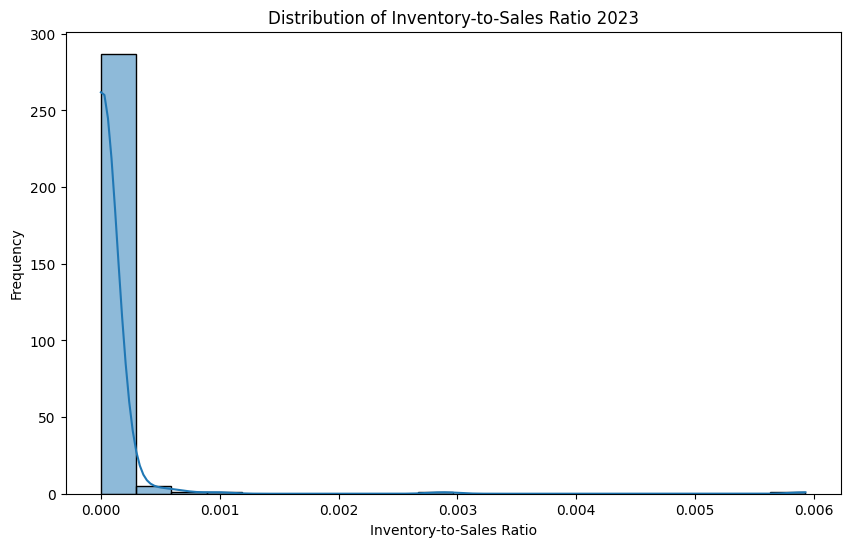

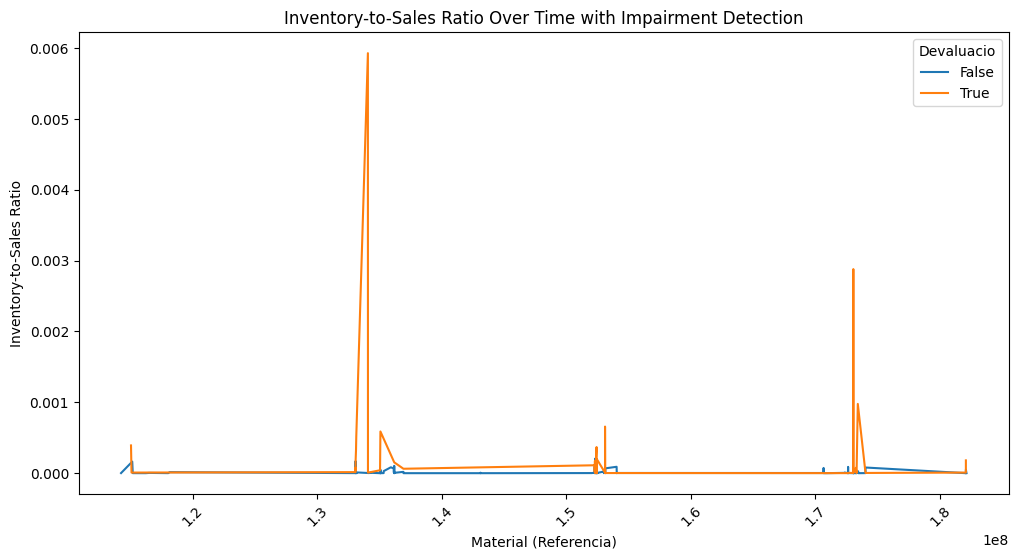

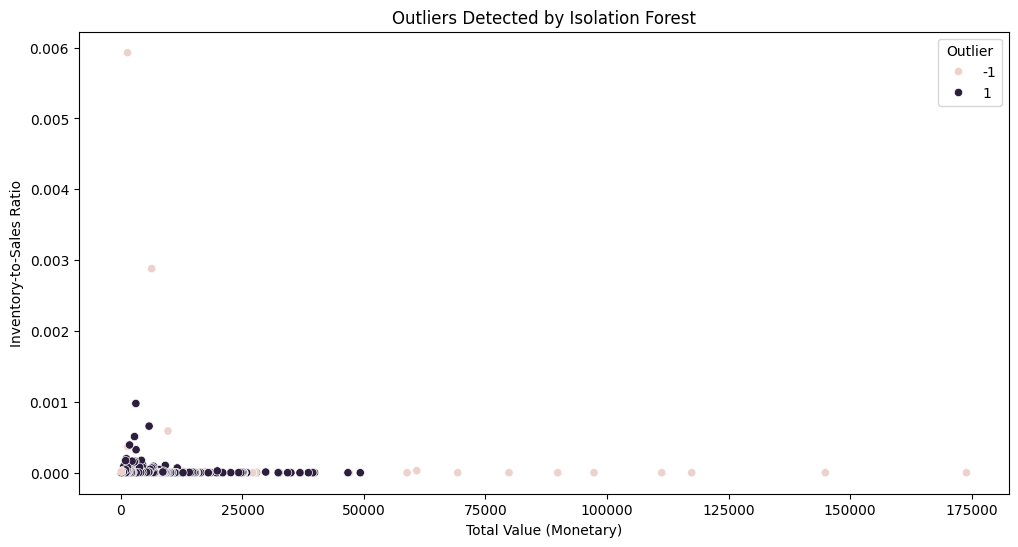

In [13]:
import seaborn as sns

def interactive_dashboard(data):
    # Visualize inventory-to-sales ratio distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(data['Inventory-to-Sales Ratio 2023'], bins=20, kde=True)
    plt.title('Distribution of Inventory-to-Sales Ratio 2023')
    plt.xlabel('Inventory-to-Sales Ratio')
    plt.ylabel('Frequency')
    plt.show()

    # Visualize potential impairments over time
    
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='Material (Referencia)', y='Inventory-to-Sales Ratio 2023', hue='Devaluacio', data=data)
    plt.title('Inventory-to-Sales Ratio Over Time with Impairment Detection')
    plt.xlabel('Material (Referencia)')
    plt.ylabel('Inventory-to-Sales Ratio')
    plt.xticks(rotation=45)
    plt.legend(title='Devaluacio')
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.scatterplot(x='Valor total', y='Inventory-to-Sales Ratio 2023', hue='Outlier', data=data)
    plt.title('Outliers Detected by Isolation Forest')
    plt.xlabel('Total Value (Monetary)')
    plt.ylabel('Inventory-to-Sales Ratio')
    plt.legend(title='Outlier', loc='upper right')
    plt.show()

interactive_dashboard(merged_df)


Sincerament igual és simplement predir l'inventory to Sales Ratio i els que siguin més de 0.0005 a tomar por culo

La veritat no sé què he fet, sincerament. La idea bàsicament és intentar detectar quins es vendran poc, però esq a penes disposem de dades històriques llavors fer un time series casi que descartat. Una de les coses que vaig veure per internet, i que si tinguèssim més dades igual es podria fer, esq feien com un time series clustering amb molts grups, i rollo alguns grups eren de productes que anaven en caiguda i altres que pujaven. Llavors a mesura que anava passant el temps, calcules a quin cluster pertany d'aquells. Si és dels que acaben en caiguda, el poses en "alerta", sinó tot chill (no ho feien amb productes pro crec que es podria aplicar).